In [1]:
%matplotlib inline

import random
import pickle
from numpy.core.records import array
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm  # progess bar
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
import random

In [3]:
def dropout(X, i):
    X = np.array(X)
    N = X.shape[0]
    X_change = np.copy(X)
    X_change[:, i] = np.ones(N) * np.mean(X[:, i])
    #X_change = as_tensor(X_change)
    return X_change

def generate_data(beta, sigma = 0.1, N=5000, seed =1, corr = 0.5):
    random.seed(seed)
    cov = [[1, corr],[corr, 1]]
    beta= np.array(beta, dtype = float)
    p = beta.shape[0]
    VI_true = beta**2
    VI_true[0:2] = VI_true[0:2]*(1 - corr**2)
    X = np.random.normal(0,1, size = (N,p))
    X[:,np.array([0,1])] = np.random.multivariate_normal([0,0], cov, size = N)
    normal_noise = np.random.normal(0,sigma, size = N)
    EY = np.matmul(X, beta)
    Y = EY + normal_noise

    #X = as_tensor(X)
    #Y = as_tensor(Y).view(-1,1)
    #Y_binary = as_tensor(np.array(Y_binary))
    return X, Y, VI_true

In [65]:
beta = [1.5,1.2,1,0,0,0]
p = len(beta)
X, y, tru = generate_data(beta, corr=.99)


In [84]:
tru

array([0.044775, 0.028656, 1.      , 0.      , 0.      , 0.      ])

In [66]:
model = sm.OLS(y,X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.947e+05
Date:                Mon, 13 Sep 2021   Prob (F-statistic):                        0.00
Time:                        17:50:33   Log-Likelihood:                          4444.8
No. Observations:                5000   AIC:                                     -8878.
Df Residuals:                    4994   BIC:                                     -8838.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4967      0.010    149.426      0.000       1.477       1.516
x2             1.2020      0.010    120.069      0.000       1.182       1.222
x3             1.0021      0.001    713.173      0.000       0.999       1.005
x4             0.0011      0.001      0.765      0.444      -0.002       0.004
x5             0.0013      0.001      0.907      0.364      -0.001       0.004
x6            -0.0009      0.001     -0.681      0.496      -0.004       0.002
==============================================================================
Omnibus:                        3.140   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                3.158
Skew:                           0.061   Prob(JB):                        0.206
Kurtosis:                       2.983   Cond. No.                         14.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

100%|██████████| 100/100 [00:01<00:00, 87.58it/s]


<AxesSubplot:xlabel='variable', ylabel='vi'>

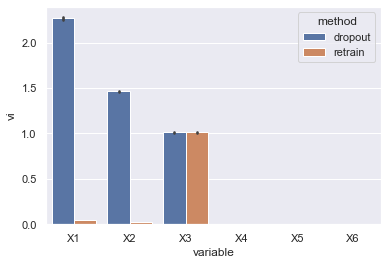

In [85]:
results = []
for t in tqdm.tqdm(np.arange(100)):
    lm = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
    lm.fit(X_train, y_train)
    yhat_test = lm.predict(X_test)
    
    for j in range(X.shape[1]):

        varr = 'X' + str(j + 1)
        # DROPOUT
        Xj_test = dropout(X_test, j)
        Xj_train = dropout(X_train, j)
        dr_vi = mse(lm.predict(Xj_test), y_test) - mse(yhat_test, y_test)
        results.append([varr, 'dropout', dr_vi])


        # RETRAIN
        lmj = LinearRegression()
        lmj.fit(Xj_train, y_train)
        rt_vi =  mse(lmj.predict(Xj_test), y_test) - mse(yhat_test, y_test)
        results.append([varr, 'retrain', rt_vi])

df = pd.DataFrame(results, columns=['variable', 'method', 'vi'])
#plt.figure(figsize=(15,5))
sns.barplot(x='variable', y='vi', hue='method', data=df)

<AxesSubplot:xlabel='variable', ylabel='vi'>

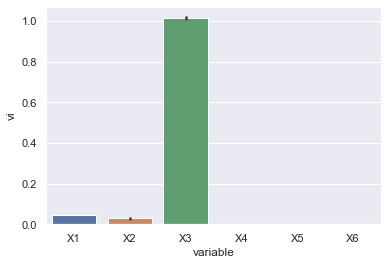

In [87]:
sns.barplot(x='variable', y='vi', data=df[df.method=='retrain'])

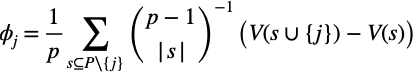

In [26]:
from itertools import chain, combinations
import math

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def subset(X, s):
    Xs = np.random.normal(size=X.shape)
    Xs[:, s] = X[:, s]
    return Xs

In [27]:
lms = LinearRegression()
lmsj = LinearRegression()

In [36]:
top = math.factorial(p-1)
comap = {}
for j in range(p):
    comap[j] = top/(math.factorial(j)*math.factorial(p-j-1))
comap

{0: 1.0, 1: 5.0, 2: 10.0, 3: 10.0, 4: 5.0, 5: 1.0}

In [119]:
results = []
diffs = []
for j in range(p):
    scores = []
    for s in powerset([x for x in np.arange(p) if x != j]):
        #Xs = subset(X, s)
        Xs = X[:, s]
        #Xsj = subset(X, list(s) + [j])
        Xsj = X[:, list(s)+[j]]
        lmsj.fit(Xsj, y)
        if len(s)==0:
            diff = max(0, r2_score(lmsj.predict(Xsj), y))
            diffs.append([s, diff])
        else:
            lms.fit(Xs, y)
            lmsj.fit(Xsj, y)
            diff = max(0, r2_score(lmsj.predict(Xsj), y)) - max(0, r2_score(lms.predict(Xs), y))
            diffs.append([s, diff])
        scores.append(diff/comap[len(s)])
    results.append(['X{}'.format(j+1), 'shapley', np.sum(scores)/p])

<AxesSubplot:xlabel='variable', ylabel='Shapley value'>

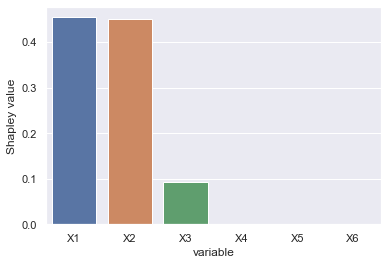

In [123]:
df = pd.DataFrame(results, columns=['variable', 'method', 'Shapley value'])

sns.barplot(x='variable', y='Shapley value', data=df)

In [106]:
diffs

[[(), 0.8561805410315411],
 [(1,), 0.00849828470700642],
 [(2,), 7.964070790139048],
 [(3,), 293151.3288648898],
 [(4,), 2128.6520925761697],
 [(5,), 5240.056271012871],
 [(1, 2), 0.005396505411905839],
 [(1, 3), 0.008499335977676492],
 [(1, 4), 0.008501672633083435],
 [(1, 5), 0.008487137355461583],
 [(2, 3), 7.9639242107705135],
 [(2, 4), 7.9406803536006345],
 [(2, 5), 7.93882776407467],
 [(3, 4), 2114.2094459504665],
 [(3, 5), 5163.523969910566],
 [(4, 5), 1499.9793916833582],
 [(1, 2, 3), 0.005395599816217178],
 [(1, 2, 4), 0.005396106929935196],
 [(1, 2, 5), 0.005396314406399094],
 [(1, 3, 4), 0.008502680413713604],
 [(1, 3, 5), 0.00848836676615694],
 [(1, 4, 5), 0.008490610910761531],
 [(2, 3, 4), 7.940544007249972],
 [(2, 3, 5), 7.938724673161331],
 [(2, 4, 5), 7.915106447558159],
 [(3, 4, 5), 1494.0737308934695],
 [(1, 2, 3, 4), 0.0053952061218608405],
 [(1, 2, 3, 5), 0.005395419341404084],
 [(1, 2, 4, 5), 0.005395904150315323],
 [(1, 3, 4, 5), 0.00849179550564716],
 [(2, 3, 4,

In [97]:
results

[['X1', 'shapley', 10190.000193867028],
 ['X2', 'shapley', 10189.996659933515],
 ['X3', 'shapley', 10186.162799930846],
 ['X4', 'shapley', -48855.28117534069],
 ['X5', 'shapley', 9532.43336957243],
 ['X6', 'shapley', 8757.68695379417]]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [88]:
import sage

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [91]:
sage_values

SAGE Explanation(
  (Mean): [ 4.05e+00  3.24e+00  9.61e-01 -6.18e-05  4.44e-05 -1.37e-05]
  (Std):  [9.74e-02 7.96e-02 5.32e-02 4.60e-05 6.26e-05 2.28e-05]
)

  0%|          | 0/1 [00:00<?, ?it/s]

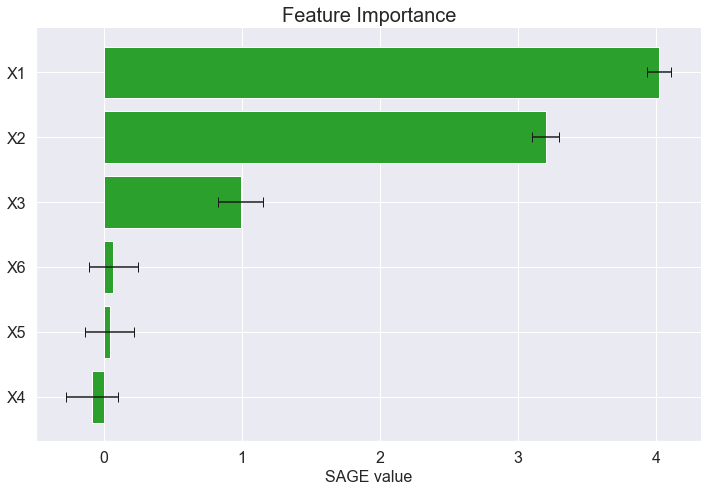

In [94]:
# et up an imputer to handle missing features
imputer = sage.MarginalImputer(lm, X_train)

# Set up an estimator
estimator = sage.KernelEstimator(imputer, 'mse')

# Calculate SAGE values
sage_values = estimator(X_train, y_train)
sage_values.plot(['X{}'.format(i+1) for i in range(p)])

In [82]:
explainer = shap.LinearExplainer(lm, X_train, feature_dependence="dependent")
shap_values = explainer.shap_values(X_test)

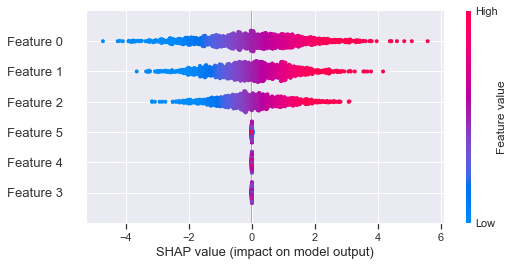

In [83]:
shap.summary_plot(shap_values, X_test)

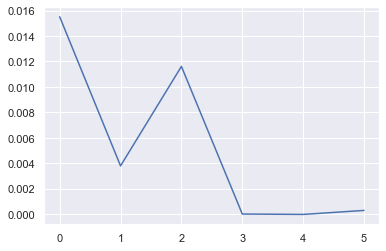

In [81]:
plt.plot(shap_values.mean(axis=0))

In [ ]:
p = X.shape[0]
j = 0
lms = LinearRegression()
lmsj = LinearRegression()
score = 0
scores = []
for s in powerset([x for x in np.arange(p) if x != j]):
    Xs = subset(X, s)
    Xsj = subset(X, list(s) + [j])
    lms.fit(Xs, y)
    lmsj.fit(Xsj, y)
    diff = r2_score(lmsj.predict(Xsj), y) - r2_score(lms.predict(Xs), y)
    scores.append(diff)
    #score += (math.factorial(len(s))*math.factorial(p-len(s) - 1)/math.factorial(p-1)*diff)
    break

In [53]:
lm.fit(Xsj,  y)
r2_score(lm.predict(Xsj), y)

0.8407368328867969

In [63]:
import math

In [66]:
def shapley(X, y, j):

    return score/p

NameError: name 'powerset' is not defined

In [65]:
len(s)

3

In [ ]:
def do_one(n_train, n_test, p, m, measure_type, binary, gamma, cor, V, conditional_mean = "nonlinear", estimator_type = "tree"):
    """
    Run the simulation one time for a given set of parameters
    @param n: sample size
    @param p: dimension
    @param m: number of subsets to sample for SGD
    @param tail: number of SGD samples to use for tail averaging
    @param measure_type: variable importance measure
    @param binary: is the outcome binary?
    @param gamma: the constant multiplied by n for sampling
    @param cor: the correlation (only used if p > 10)
    @param V: folds for cross-fitting
    @param conditional_mean: type of conditional mean (linear or nonlinear)
    @param estimator_type: the type of estimator to fit (tree or linear model)
    @return multiple values, including
        shapley_vals: the shapley values
        shapley_ics: the influence curves for the shapley values
        shap_values: the mean absolute SHAP values
        shapley_dict['num_subsets_sampled']: the number of subsets sampled
        all_mps: all measures of predictiveness
        p_values: p-values
        hyp_tests: hypothesis test decisions
        shapley_dict['beta']: the "beta" matrix, from SGD on ics
    """
    # import standard libraries
    import numpy as np
    from xgboost import XGBRegressor
    from sklearn.linear_model import LinearRegression
    import shap
    from sklearn.model_selection import GridSearchCV
    from warnings import warn

    # import user-defined functions
    import data_generator as dg
    import measures_of_predictiveness as mp
    import utils as uts
    import get_influence_functions as gif
    import compute_ic as ci
    import get_shapley_value as gsv
    import shapley_hyp_test as sht

    # generate data
    if conditional_mean == "nonlinear":
        if binary:
            func_name = "ten_variable_binary_conditional_mean"
        else:
            func_name = "ten_variable_continuous_conditional_mean"
    else:
        func_name = "lm_conditional_mean"

    beta = np.array([1, 0, 1.2, 0, 1.05, 0] + [0] * (p - 6))

    if measure_type == "r_squared":
        measure_func = mp.r_squared
        objective_function = 'reg:linear'
    else:
        measure_func = mp.auc
        objective_function = 'binary:logistic'

    data_gen = dg.DataGenerator(func_name, n_train, n_test, p, binary, beta, cor)
    draw = data_gen.create_data()
    folds_outer = np.random.choice(a = np.arange(2), size = draw.y_train.shape[0], replace = True, p = np.array([0.25, 0.75]))
    draw_0 = dg.Dataset(x_train = draw.x_train[folds_outer == 0, :], y_train = draw.y_train[folds_outer == 0], x_test = None, y_test = None)
    draw_1 = dg.Dataset(x_train = draw.x_train[folds_outer == 1, :], y_train = draw.y_train[folds_outer == 1], x_test = None, y_test = None)
    # set up args for xgboost

    # use the cross-validated selector to get the number of trees
    ntrees_tree = np.array([50, 100, 250, 500, 1000, 1500, 2000, 2500, 3000])
    lambdas_tree = np.array([1e-3, 1e-2, 1e-1, 1, 5, 10])
    param_grid_tree = [{'n_estimators': ntrees_tree, 'reg_alpha': lambdas_tree}]
    # estimate full regression
    if estimator_type == "tree":
        cv_tree = GridSearchCV(XGBRegressor(objective = objective_function, max_depth = 1, verbosity = 0, learning_rate = 1e-2, reg_lambda = 0), param_grid = param_grid_tree, cv = 5)
        cv_tree.fit(draw.x_train, np.ravel(draw.y_train))
        ensemble_tree = XGBRegressor(objective = objective_function, max_depth = 1, verbosity = 0, reg_lambda = 0, learning_rate = 1e-2, n_estimators = cv_tree.best_params_['n_estimators'], reg_alpha = cv_tree.best_params_['reg_alpha'])
        ensemble = ensemble_tree
        print("Num. est. in boosted tree: " + str(cv_tree.best_params_['n_estimators']))
    else:
        ensemble = LinearRegression(fit_intercept = False)
    # get a list of n subset sizes, Ss, Zs
    max_subset = np.array(list(range(p)))
    sampling_weights = np.append(np.append(1, [uts.choose(p - 2, s - 1) ** (-1) for s in range(1, p)]), 1)
    subset_sizes = np.random.choice(np.arange(0, p + 1), p = sampling_weights / sum(sampling_weights), size = draw.x_train.shape[0] * gamma, replace = True)
    S_lst_all = [np.sort(np.random.choice(np.arange(0, p), subset_size, replace = False)) for subset_size in list(np.sort(subset_sizes))]
    # only need to continue with the unique subsets S
    Z_lst_all = [np.in1d(max_subset, S).astype(np.float64) for S in S_lst_all]
    Z, z_counts = np.unique(np.array(Z_lst_all), axis = 0, return_counts = True)
    Z_lst = list(Z)
    Z_aug_lst = [np.append(1, z) for z in Z_lst]
    S_lst = [max_subset[z.astype(bool).tolist()] for z in Z_lst]
    if estimator_type == "tree":
        cv_tree_small = GridSearchCV(XGBRegressor(objective = objective_function, max_depth = 1, verbosity = 0, learning_rate = 1e-2, reg_lambda = 0), param_grid = param_grid_tree, cv = 5)
        all_s_sizes = [len(s) for s in S_lst[1:]]
        s_sizes = np.unique(all_s_sizes)
        all_best_tree_lst = [None] * len(S_lst[1:])
        all_best_lambda_lst = [None] * len(S_lst[1:])
        for i in range(s_sizes.shape[0]):
            indx = all_s_sizes.index(s_sizes[i])
            this_s = S_lst[1:][indx]
            cc_i = (np.sum(np.isnan(draw_1.x_train[:, this_s]), axis = 1) == 0)
            these_best_params = cv_tree_small.fit(draw_1.x_train[:, this_s][cc_i, :], np.ravel(draw_1.y_train[cc_i])).best_params_
            all_indices = [index for index, value in enumerate(all_s_sizes) if value == s_sizes[i]]
            all_best_tree_lst = [these_best_params['n_estimators'] if x in all_indices else all_best_tree_lst[x] for x in range(len(all_best_tree_lst))]
            all_best_lambda_lst = [these_best_params['reg_alpha'] if x in all_indices else all_best_lambda_lst[x] for x in range(len(all_best_lambda_lst))]
        ensemble_funcs = [XGBRegressor(objective = objective_function, max_depth = 1, verbosity = 0, reg_lambda = 0, reg_alpha = all_best_lambda_lst[i], learning_rate = 1e-2, n_estimators = all_best_tree_lst[i]) for i in range(len(all_best_tree_lst))]
    else:
        ensemble_funcs = [ensemble for i in range(len(S_lst[1:]))]
    # get v, preds, ic for each unique S
    preds_none = np.repeat(np.mean(draw_1.y_train), draw_1.x_train.shape[0])
    v_none = measure_func(draw_1.y_train, preds_none)
    ic_none = ci.compute_ic(draw_1.y_train, preds_none, measure_type)
    # get v, preds, ic for the remaining non-null groups
    v_lst, preds_lst, ic_lst, folds = zip(*(mp.cv_predictiveness(draw_1, S_lst[1:][i], measure_func, ensemble_funcs[i], V = V, stratified = binary, na_rm = False) for i in range(len(S_lst[1:]))))
    v_lst_all = [v_none] + list(v_lst)
    ic_lst_all = [ic_none] + list(ic_lst)
    # set up Z, v, W, G, c_n matrices
    Z = np.array(Z_aug_lst)
    # constrain v >= 0
    v = np.maximum(np.array(v_lst_all), 0)
    W = np.diag(z_counts / np.sum(z_counts))
    G = np.vstack((np.append(1, np.zeros(p)), np.ones(p + 1) - np.append(1, np.zeros(p))))
    c_n = np.array([v_none, v_lst_all[len(v_lst)] - v_none])
    # do constrained least squares
    A_W = np.sqrt(W).dot(Z)
    v_W = np.sqrt(W).dot(v)
    kkt_matrix = uts.create_kkt_matrix(A_W, G)
    ls_matrix = np.vstack((2 * A_W.transpose().dot(v_W.reshape((len(v_W), 1))), c_n.reshape((c_n.shape[0], 1))))
    ls_solution = np.linalg.pinv(kkt_matrix).dot(ls_matrix)
    shapley_vals = ls_solution[0:(p + 1), :]

    # get relevant objects
    shapley_ics = gif.shapley_influence_function(Z, z_counts, W, v, shapley_vals, G, c_n, np.array(ic_lst_all), measure_func.__name__)
    # if any shapley values are < 0, make zero and print a warning
    if any(shapley_vals < 0):
        if any(shapley_vals[1:] < 0):
            warn("At least one estimated shapley value is < 0. Setting to 0.")
        shapley_vals = np.maximum(shapley_vals, 0)
    if any(shapley_vals > 1):
        if any(shapley_vals[1:] > 1):
            warn("At least one estimated shapley value is > 1. Setting to 1.")
        shapley_vals = np.minimum(shapley_vals, 1)

    # do hypothesis test
    # get the null predictiveness on a separate split
    preds_none_0 = np.repeat(np.mean(draw_0.y_train), draw_0.x_train.shape[0])
    v_none_0 = measure_func(draw_0.y_train, preds_none_0)
    ic_none_0 = ci.compute_ic(draw_0.y_train, preds_none_0, measure_type)
    sigma_none_0 = np.sqrt(np.mean((ic_none_0) ** 2)) / np.sqrt(np.sum(draw_0.y_train.shape[0]))
    # get the shapley values + null predictiveness on the first split
    shapley_vals_plus = shapley_vals + shapley_vals[0]
    sigmas_one = [np.sqrt(gsv.shapley_se(shapley_ics, i, gamma) ** 2 + sigma_none_0 ** 2) for i in range(1, p + 1)]
    test_statistics, p_values, hyp_tests = sht.shapley_hyp_test(shapley_vals_plus[1:], v_none_0, sigmas_one, sigma_none_0, level = 0.05, p = p)

    # get variable importance using SHAP values
    if estimator_type == "tree":
        mod = XGBRegressor(objective = objective_function, learning_rate = 1e-2, reg_lambda = 0, max_depth = 1, n_estimators = cv_tree.best_params_['n_estimators'], reg_alpha = cv_tree.best_params_['reg_alpha'], verbosity = 0)
        mod.fit(draw.x_train, draw.y_train)
        explainer = shap.TreeExplainer(mod)
    else:
        mod = LinearRegression(fit_intercept = False)
        mod.fit(draw.x_train, draw.y_train)
        explainer = shap.LinearExplainer((np.ravel(mod.coef_), 0), draw.x_train, feature_dependence = 'correlation', nsamples = 500)

    shap_values = explainer.shap_values(draw.x_test)

    # return the population shapley values and averaged prediction-level shapley values
    return shapley_vals, shapley_ics, shap_values, Z.shape[0], v, p_values, hyp_tests